In [1]:
from matplotlib import pyplot as plt
import pandas as pd

df = pd.concat((
    pd.read_csv('./out/replay_results.csv', index_col=[0, 1]),
    pd.read_csv('./out/replay_results_baseline.csv', index_col=[0, 1]),
))

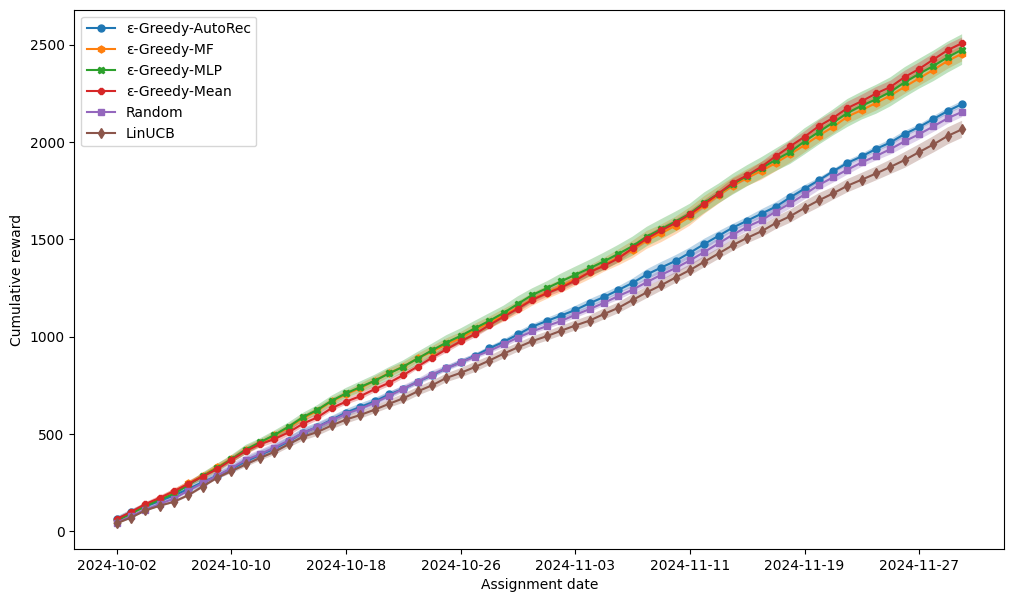

In [2]:
plt.figure(figsize=(12, 7))
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
for marker, (name, group) in zip(['o', 'h', 'X', '8', 's', 'd'], df.groupby(level=0, sort=False)):
    m = group.mean(axis=1)
    s = group.std(axis=1)

    CI_min = m - 1.96 * s / group.shape[1] ** 0.5
    CI_max = m + 1.96 * s / group.shape[1] ** 0.5

    plt.plot(group.index.get_level_values(1), m, label=name, marker=marker, markersize=5)
    plt.fill_between(group.index.get_level_values(1), CI_min, CI_max, alpha=0.3)

#plt.title('Cumulative reward from 2024-10-01 to 2024-11-30')
plt.ylabel('Cumulative reward')
plt.xlabel('Assignment date')
plt.legend()
plt.savefig('./out/cumulative_reward.pdf', format='pdf', bbox_inches='tight')
plt.show()

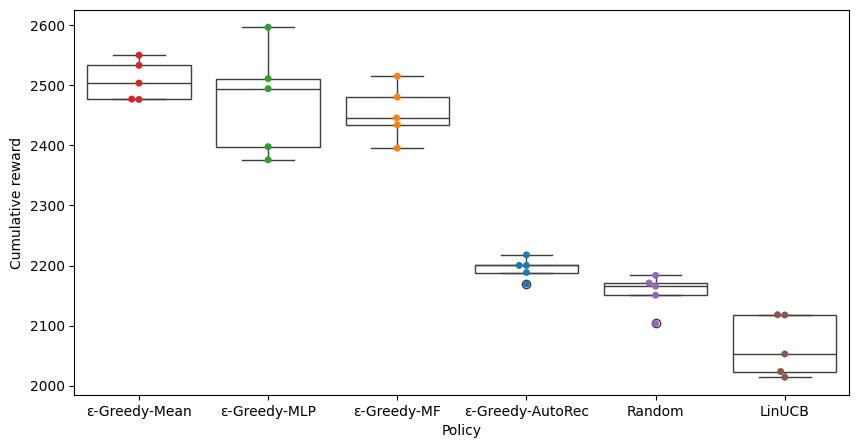

In [3]:
import seaborn as sns
lasted = df.groupby(level=0, sort=False).last().T
rank = lasted.median().sort_values(ascending=False).index

plt.figure(figsize=(10, 5))
sns.boxplot(data=lasted, color='white', order=rank)
sns.swarmplot(data=lasted)
#plt.title('Cumulated reward distribution at 2024-11-30')
plt.ylabel('Cumulative reward')
plt.xlabel('Policy')
plt.savefig('./out/cumulative_reward_2.pdf', format='pdf')
plt.show()